# PUBG Data Exploration + Random Forest

# Table of Contents

* [Preparation](#1)
* [Initial Exploration](#3)
* [Illegal Match](#4)
* [Feature Engineering](#5)
* [Outlier Detection](#6)
* [Categorical Variables](#7)
* [Preparation for Machine Learning](#8)
* [Feature Importance](#9)
* [Final Random Forest Model](#10)
* [Kaggle Submission](#11)


# Preparation <a id="1"></a>

需要的一些依赖包
* [Pandas](https://pandas.pydata.org) 
* [Matplotlib](https://matplotlib.org) 
* [Scikit-learn](https://scikit-learn.org/stable) .
* [fastai](https://www.fast.ai) 

In [3]:
# 自动重载
%load_ext autoreload
%autoreload 2
# 不需要plot.show()即可画图
%matplotlib inline

# 标准库
import os
import numpy as np
import pandas as pd

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox import pdp
from plotnine import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

# 机器学习
import sklearn
from sklearn import metrics
from scipy.cluster import hierarchy as hc
from fastai.imports import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# from fastai.structured import *

kaggle提供的数据集

In [5]:
# Import dataset
KAGGLE_DIR = '../PUBGData/'
train = pd.read_csv(KAGGLE_DIR + 'train_V2.csv')
test = pd.read_csv(KAGGLE_DIR + 'test_V2.csv')

# Initial Exploration <a id="3"></a>

查看数据结构

In [6]:
# 前面5行
print('First 5 rows: ')
display(train.head())

# 最后5行
print('Last 5 rows: ')
display(train.tail())

First 5 rows: 


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


Last 5 rows: 


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0,0,0.000,0,0,1019.0,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0,0,0.000,0,0,81.7,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0,0,2.184,0,0,788.7,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0,0,0.000,0,0,2748.0,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.00,0,0,1,18,...,0,1369.0,0,0.000,0,0,1244.0,5,0,0.5464


In [7]:
# Stats
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


数据类型长度以及占用空间

In [8]:
# Types, Data points, memory usage, etc.
train.info()

# Check dataframe's shape
print('Shape of training set: ', train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB
Shape of training set:  (4446966, 29)


### Feature descriptions (From Kaggle)

关于数据集的说明，详情请看PUBG.ipynb

[kaggle原问题](https://www.kaggle.com/c/pubg-finish-placement-prediction/data)

In [9]:
# Use this code if you want to store and read DataFrames in a feather format
# os.makedirs('tmp', exist_ok=True)
# train.to_feather('tmp/PUBG')
# df_raw = pd.read_feather('tmp/PUBG')

# Illegal Match <a id="4"></a>

当比赛只有一名玩家的时候，玩家的排名会是NAN

In [10]:
# 查找NAN的玩家
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


删除异常数据

In [11]:
train.drop(2744604, inplace=True)

In [12]:
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


# Feature Engineering <a id="5"></a>

根据PUBG.ipynb我们已经构造了一些有趣的特征

### Players Joined

参与玩家人数

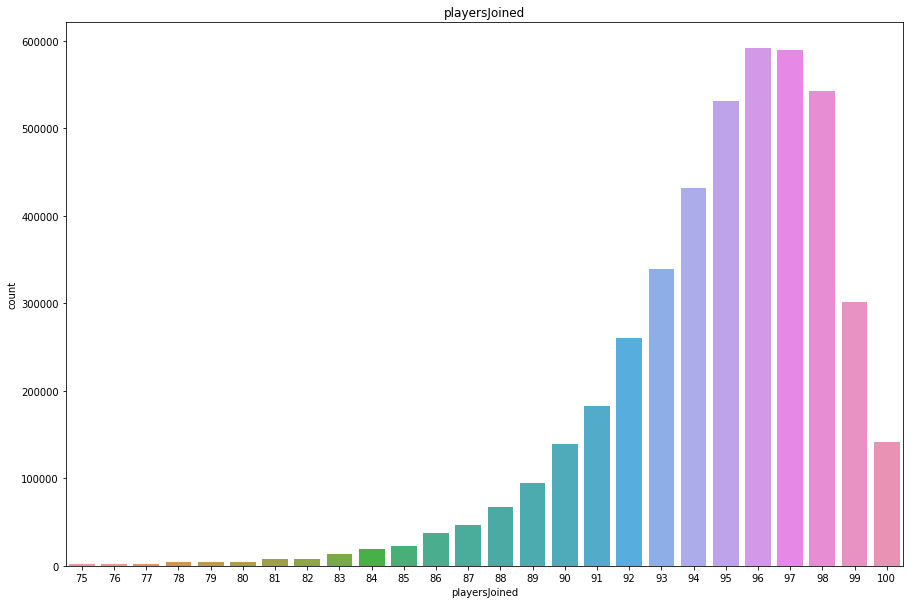

In [13]:
# playersJoined
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(15,10))
sns.countplot(train[train['playersJoined']>=75]['playersJoined'])
plt.title('playersJoined')
plt.show()

大部分比赛的玩家数量在75名以上

### Normalized features

构建新特征playersJoined

In [14]:
# 数据标准化处理
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train['maxPlaceNorm'] = train['maxPlace']*((100-train['playersJoined'])/100 + 1)
train['matchDurationNorm'] = train['matchDuration']*((100-train['playersJoined'])/100 + 1)
# 将原有数据与标准化后的数据进行对比
to_show = ['Id', 'kills','killsNorm','damageDealt', 'damageDealtNorm', 'maxPlace', 'maxPlaceNorm', 'matchDuration', 'matchDurationNorm']
train[to_show][0:11]

,Id,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000,0.00000,28,29.12,1306,1358.24
1,eef90569b9d03c,0,0.00,91.470,99.70230,26,28.34,1777,1936.93
2,1eaf90ac73de72,0,0.00,68.000,69.36000,50,51.00,1318,1344.36
3,4616d365dd2853,0,0.00,32.900,35.86100,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.03,100.000,103.00000,97,99.91,1424,1466.72
5,ff79c12f326506,1,1.05,100.000,105.00000,28,29.40,1395,1464.75
6,95959be0e21ca3,0,0.00,0.000,0.00000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538,8.87952,96,99.84,1967,2045.68
8,1a68204ccf9891,0,0.00,51.600,53.14800,28,28.84,1375,1416.25
9,e5bb5a43587253,0,0.00,37.270,38.38810,29,29.87,1930,1987.90


### Heals and Boosts

We create a feature called 'healsandboosts' by adding heals and boosts. (duh!) We are not sure if this has additional predictive value, but we can always delete it later if the feature importance according to our random forest model is too low.

In [13]:
# Create new feature healsandboosts
train['healsandboosts'] = train['heals'] + train['boosts']
train[['heals', 'boosts', 'healsandboosts']].tail()

,heals,boosts,healsandboosts
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


### Killing without moving

We try to identify cheaters by checking if people are getting kills without moving. We first identify the totalDistance travelled by a player and then set a boolean value to True if someone got kills without moving a single inch. We will remove cheaters in our outlier detection section.

In [15]:
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))

The feature headshot_rate will also help us to catch cheaters.

In [16]:
# Create headshot_rate feature
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

# Outlier Detection <a id="6"></a>

Some rows in our dataset have really weird characteristics. The players could be cheaters, maniacs or just anomalies. Removing these outliers will most likely improve results.

Inspiration for this section comes from [this amazing Kaggle Kernel.](https://www.kaggle.com/rejasupotaro/cheaters-and-zombies)

![Alt Text](https://media.giphy.com/media/OPRbXcsGctvZC/giphy.gif)

**Kills without movement**

This is perhaps the most obvious sign of cheating in the game. It is already fishy if a player hasn't moved during the whole game, but the player could be AFK and got killed. However, if the player managed to get kills it is most likely a cheater.

In [17]:
display(train[train['killsWithoutMoving'] == True].shape)
train[train['killsWithoutMoving'] == True].head(10)

(1535, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.00,0,0,3,18,...,0.8571,58,8.52,842.0600,21.30,842.06,3,0.0,True,0.000000
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.60,0,0,6,33,...,0.6000,42,4.74,547.6280,17.38,2834.52,6,0.0,True,0.000000
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.00,0,4,5,3,...,0.8947,21,35.80,3132.5000,35.80,1607.42,5,0.0,True,0.200000
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.80,0,0,0,69,...,0.0000,73,1.27,200.4060,24.13,1014.73,0,0.0,True,0.000000
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.00,0,1,0,37,...,0.3000,42,1.58,158.0000,17.38,2834.52,0,0.0,True,1.000000
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.10,4,1,3,7,...,0.8000,44,9.36,789.5160,9.36,909.48,3,0.0,True,0.166667
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.00,0,4,1,7,...,0.6000,48,18.24,1708.4800,9.12,836.00,1,0.0,True,0.333333
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.90,0,2,11,12,...,0.8571,57,10.01,757.7570,21.45,856.57,11,0.0,True,0.285714
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.90,0,1,6,53,...,0.2857,61,2.78,179.1710,11.12,1017.48,7,0.0,True,0.500000
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.56,0,0,0,46,...,0.8571,53,1.47,125.7732,22.05,1051.05,0,0.0,True,0.000000


Got the suckers! 

In [18]:
# Remove outliers
train.drop(train[train['killsWithoutMoving'] == True].index, inplace=True)

**Anomalies in roadKills**

In [19]:
# Players who got more than 10 roadKills
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,...,0.4286,92,15.12,1345.68,99.36,1572.48,0,1282.302,False,0.000000
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,...,0.4713,88,12.32,1234.24,98.56,2179.52,0,4934.600,False,0.000000
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,...,1.0000,38,32.40,3359.88,61.56,3191.40,19,5876.000,False,0.050000
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,...,0.9398,84,20.88,2164.56,97.44,2233.00,10,7853.000,False,0.277778


In [20]:
train.drop(train[train['roadKills'] > 10].index, inplace=True)

Note that player c3e444f7d1289d drove 5 meters but killed 14 people with it. Sounds insane doesn't it?

![Alt Text](https://media.giphy.com/media/3o7aD85usFbbbrCR3i/giphy.gif)

**Anomalies in aim (More than 45 kills)**

Let's plot the total kills for every player first. It doesn't look like there are too many outliers.

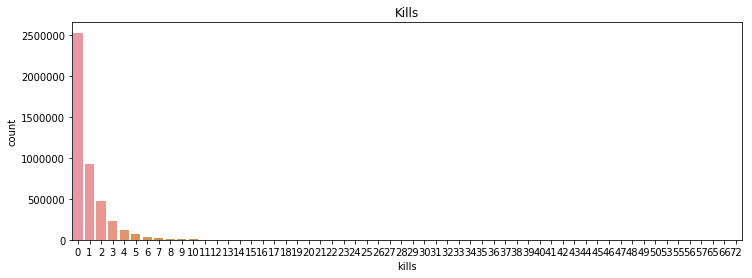

In [21]:
plt.figure(figsize=(12,4))
sns.countplot(data=train, x=train['kills']).set_title('Kills')
plt.show()

Let's take a closer look.

In [22]:
# Players who got more than 30 kills
display(train[train['kills'] > 30].shape)
train[train['kills'] > 30].head(10)

(95, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
57978,9d8253e21ccbbd,ef7135ed856cd8,37f05e2a01015f,9,0,3725.0,0,7,0,2,...,0.8571,16,64.40,6854.00,14.72,3308.32,0,48.82,False,0.200000
87793,45f76442384931,b3627758941d34,37f05e2a01015f,8,0,3087.0,0,8,27,3,...,1.0000,16,57.04,5680.08,14.72,3308.32,27,780.70,False,0.258065
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,...,0.7000,11,90.72,10355.31,20.79,3398.22,7,23.71,False,0.250000
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,...,1.0000,62,57.96,5565.54,11.04,1164.72,0,718.30,False,0.952381
180189,1355613d43e2d0,f863cd38c61dbf,39c442628f5df5,5,0,3171.0,0,6,15,1,...,1.0000,11,66.15,5993.19,17.01,3394.44,15,71.51,False,0.171429
334400,810f2379261545,7f3e493ee71534,f900de1ec39fa5,20,0,6616.0,0,13,5,1,...,1.0000,11,122.85,12504.24,20.79,3398.22,5,1036.00,False,0.200000
353128,f3e9746e3ff151,4bc1f00f07b304,a9e84c456cc859,2,0,3834.0,0,9,5,1,...,1.0000,13,72.93,7169.58,24.31,3356.65,5,124.20,False,0.230769
457829,265e23756baa0b,9d94424171c2a1,664dee9ed8f646,3,0,2907.0,0,27,2,1,...,1.0000,38,53.46,4709.34,8.10,1339.74,2,382.40,False,0.818182
488335,31a0682922ef45,275a27a3ee4cc8,3037f74ef8a3a3,2,0,3055.0,0,9,0,1,...,1.0000,20,59.40,5499.00,32.40,1605.60,0,35.30,False,0.272727
662650,dd424a8b74bd49,ac9dea6d62f2e6,8a728def0644be,9,0,3454.0,38,9,4,1,...,0.2308,54,49.64,5042.84,20.44,1749.08,4,111.10,False,0.264706


In [23]:
# Remove outliers
train.drop(train[train['kills'] > 30].index, inplace=True)

What do you think? Should we remove all these outliers from our dataset?

**Anomalies in aim part 2 (100% headshot rate)**

Again, we first take a look at the whole dataset and create a new feature 'headshot_rate'.
We see that the most players score in the 0 to 10% region. However, there are a few anomalies that have a headshot_rate of 100% percent with more than 9 kills!

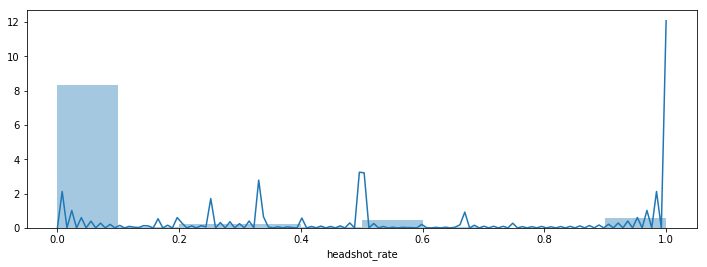

In [24]:
plt.figure(figsize=(12,4))
sns.distplot(train['headshot_rate'], bins=10)
plt.show()

In [25]:
# Players who made a minimum of 10 kills and have a headshot_rate of 100%
display(train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].shape)
train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].head(10)

(24, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,...,0.8462,93,10.70,1296.84,28.89,1522.61,3,2939.0,False,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,...,1.0000,96,11.44,1684.80,28.08,1796.08,8,8142.0,False,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,...,1.0000,98,13.26,1392.30,27.54,1280.10,4,2105.0,False,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,...,0.9630,95,10.50,1611.75,29.40,1929.90,8,7948.0,False,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,...,1.0000,96,10.40,1409.20,28.08,1473.68,8,3476.0,False,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,...,1.0000,95,11.55,1278.90,29.40,1912.05,8,8178.0,False,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,...,1.0000,97,10.30,1096.95,27.81,1283.38,5,2858.9,False,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,...,1.0000,93,12.84,1411.33,29.96,1851.10,6,5963.0,False,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,...,1.0000,88,12.32,1288.00,51.52,1397.76,5,3108.0,False,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,...,1.0000,96,13.52,1537.12,50.96,1434.16,12,2479.8,False,1.0


It is unclear if these players are cheating so we are probably not deleting these players from the dataset.
If they are legitimate players, they are probably really crushing the game!

![Alt Text](https://media.giphy.com/media/l3mZrOajz5VCZf7Hy/giphy.gif)


**Anomalies in aim part 3 (Longest kill)**

Most kills are made from a distance of 100 meters or closer. There are however some outliers who make a kill from more than 1km away. This is probably done by cheaters.

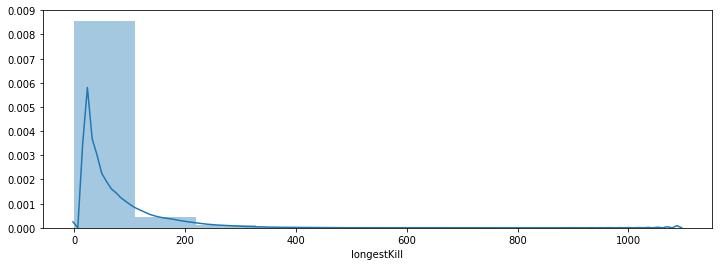

In [26]:
plt.figure(figsize=(12,4))
sns.distplot(train['longestKill'], bins=10)
plt.show()

Let's take a look at the players who make these shots.

In [27]:
display(train[train['longestKill'] >= 1000].shape)
train[train['longestKill'] >= 1000].head(10)

(20, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.9,5,1,1,5,...,0.9231,88,4.48,877.968,30.24,2087.68,4,3775.20,False,0.250000
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.0,8,5,7,18,...,0.5385,29,18.81,2195.640,23.94,2236.68,7,48.87,False,0.454545
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.0,0,0,0,9,...,1.0000,51,14.90,1531.720,19.37,1040.02,0,2981.00,False,0.000000
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.0,17,5,0,3,...,0.6000,41,25.44,2241.900,9.54,1734.69,0,29.21,False,0.312500
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.8,0,0,0,51,...,0.0000,61,1.39,273.552,11.12,654.69,0,3159.00,False,0.000000
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.0,11,5,0,5,...,0.9091,86,11.40,1153.680,13.68,1163.94,0,569.50,False,0.500000
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.3,0,0,2,45,...,0.2857,58,4.26,467.606,11.36,825.02,3,832.50,False,0.000000
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.0,0,7,0,1,...,0.9412,52,22.20,2427.200,76.96,1827.80,6,2848.00,False,0.466667
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.0,0,4,11,11,...,0.5000,28,39.56,3617.160,25.80,3092.56,13,235.30,False,0.173913
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.0,0,6,5,15,...,0.6000,42,17.38,2057.160,17.38,2834.52,8,133.20,False,0.545455


In [28]:
# Remove outliers
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

There is something fishy going on with these players. We are probably better off removing them from our dataset.

![Alt Text](https://media.giphy.com/media/RHJkLqcdvMQF4GI3P7/giphy.gif)

**Anomalies in travelling (rideDistance, walkDistance and swimDistance)**

Let's check out anomalies in Distance travelled.

In [29]:
train[['walkDistance', 'rideDistance', 'swimDistance', 'totalDistance']].describe()

,walkDistance,rideDistance,swimDistance,totalDistance
count,4.445311e+06,4.445311e+06,4.445311e+06,4.445311e+06
mean,1.154628e+03,6.063272e+02,4.510977e+00,1.765466e+03
std,1.183514e+03,1.498567e+03,3.050773e+01,2.183257e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.554000e+02,0.000000e+00,0.000000e+00,1.584000e+02
50%,6.864000e+02,0.000000e+00,0.000000e+00,7.893000e+02
75%,1.977000e+03,2.606500e-01,0.000000e+00,2.729000e+03
max,2.578000e+04,4.071000e+04,3.823000e+03,4.127010e+04


**walkDistance**

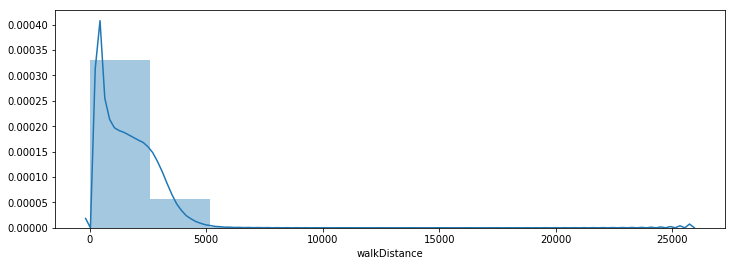

In [30]:
plt.figure(figsize=(12,4))
sns.distplot(train['walkDistance'], bins=10)
plt.show()

In [31]:
# walkDistance anomalies
display(train[train['walkDistance'] >= 10000].shape)
train[train['walkDistance'] >= 10000].head(10)

(219, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.00,0,0,0,44,...,0.8163,99,0.00,0.0000,99.99,1925.06,1,13540.3032,False,0.0
34344,5a591ecc957393,6717370b51c247,a15d93e7165b05,0,3,23.22,0,0,1,34,...,0.9474,65,0.00,31.3470,27.00,2668.95,4,10070.9073,False,0.0
49312,582685f487f0b4,338112cd12f1e7,d0afbf5c3a6dc9,0,4,117.20,1,0,1,24,...,0.9130,94,1.06,124.2320,49.82,2323.52,5,12446.7588,False,0.0
68590,8c0d9dd0b4463c,c963553dc937e9,926681ea721a47,0,1,32.34,0,0,1,46,...,0.8333,96,0.00,33.6336,50.96,1909.44,2,12483.6200,False,0.0
94400,d441bebd01db61,7e179b3366adb8,923b57b8b834cc,1,1,73.08,0,0,3,27,...,0.8194,73,0.00,92.8116,92.71,2293.62,4,11490.6300,False,0.0
125103,db5a0cdc969dcb,50cc466757950e,c306a9745c4c1d,0,4,37.73,0,0,7,47,...,0.7340,95,0.00,39.6165,99.75,2054.85,11,12828.7978,False,0.0
136421,955e60b09a96b1,30df08fe22a901,8669d01725f135,0,1,0.00,0,0,1,46,...,0.6957,94,0.00,0.0000,49.82,2091.38,2,12223.8100,False,0.0
136476,0d75d05b5c988c,3da040ce77cd0b,65bc5211a569dd,0,3,0.00,0,0,0,41,...,0.9333,91,0.00,0.0000,99.19,2028.49,3,14918.2000,False,0.0
154080,7e8a71d23381cd,e2c9f4f92840b2,a721de1aa05408,0,3,0.00,0,0,13,46,...,0.8602,94,0.00,0.0000,99.64,2038.38,16,12636.7000,False,0.0
154128,32fdde4c716787,390ae9a51c11b8,82610ed1b4d033,0,4,52.16,0,0,7,25,...,0.8936,95,1.05,54.7680,50.40,1927.80,11,10889.8614,False,0.0


In [32]:
# Remove outliers
train.drop(train[train['walkDistance'] >= 10000].index, inplace=True)

**rideDistance**

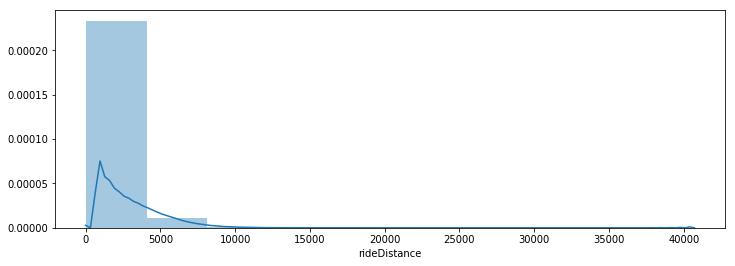

In [33]:
plt.figure(figsize=(12,4))
sns.distplot(train['rideDistance'], bins=10)
plt.show()

In [34]:
# rideDistance anomalies
display(train[train['rideDistance'] >= 20000].shape)
train[train['rideDistance'] >= 20000].head(10)

(150, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
28588,6260f7c49dc16f,b24589f02eedd7,6ebea3b4f55b4a,0,0,99.20,0,0,1,30,...,0.6421,96,1.04,103.1680,99.84,1969.76,1,26306.60,False,0.000000
63015,adb7dae4d0c10a,8ede98a241f30a,8b36eac66378e4,0,0,0.00,0,0,0,55,...,0.5376,94,0.00,0.0000,99.64,2004.46,0,22065.40,False,0.000000
70507,ca6fa339064d67,f7bb2e30c3461f,3bfd8d66edbeff,0,0,100.00,0,0,0,26,...,0.8878,99,1.01,101.0000,99.99,1947.28,0,28917.50,False,0.000000
72763,198e5894e68ff4,ccf47c82abb11f,d92bf8e696b61d,0,0,0.00,0,0,0,46,...,0.7917,97,0.00,0.0000,99.91,1861.21,0,21197.20,False,0.000000
95276,c3fabfce7589ae,15529e25aa4a74,d055504340e5f4,0,7,778.20,0,1,2,2,...,0.9785,94,7.42,824.8920,99.64,1986.44,9,26733.20,False,0.142857
140097,9944fbbea2b91e,18b4d5f4bb1906,d9d4a3e50cae75,1,0,12.55,0,0,0,53,...,0.5000,89,0.00,13.9305,98.79,2107.89,0,21293.23,False,0.000000
297186,88904c200175b6,012a61a01e146e,7a270c25e9b70c,0,1,0.00,0,0,1,47,...,0.7447,96,0.00,0.0000,49.92,1995.76,2,29267.30,False,0.000000
371098,f7071357f6b762,f3ee20821f4627,ac47c86bf385bf,0,0,72.92,1,0,0,45,...,0.6875,96,0.00,75.8368,50.96,1953.12,0,21942.10,False,0.000000
403647,c65da7b3fceef5,814d1b3736e276,ff9f570b555d48,0,2,0.00,0,0,3,54,...,0.6739,94,0.00,0.0000,49.82,1930.26,5,21198.20,False,0.000000
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.00,0,0,2,43,...,0.8171,83,0.00,0.0000,97.11,2348.19,4,32362.10,False,0.000000


In [35]:
# Remove outliers
train.drop(train[train['rideDistance'] >= 20000].index, inplace=True)

Cheaters or do they just like to ride like these guys?

![Alt Text](https://media.giphy.com/media/qlCFjkSruesco/giphy.gif)

**swimDistance**

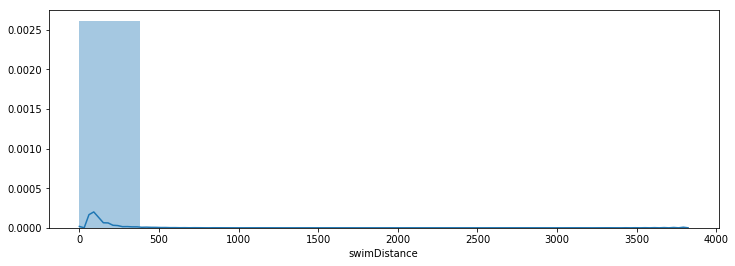

In [36]:
plt.figure(figsize=(12,4))
sns.distplot(train['swimDistance'], bins=10)
plt.show()

In [37]:
train[train['swimDistance'] >= 2000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.12,1,0,1,47,...,0.9592,98,0.00,79.6824,51.00,1426.98,6,3297.000,False,0.000000
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.32,0,0,16,39,...,0.9600,94,0.00,56.5192,27.56,2319.28,20,10113.000,False,0.000000
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.00,4,3,1,6,...,1.0000,88,3.36,563.3600,29.12,2124.64,2,10740.000,False,1.000000
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.30,3,1,6,4,...,1.0000,98,5.10,359.3460,49.98,1423.92,13,3083.100,False,0.200000
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.20,3,1,1,46,...,1.0000,86,2.28,671.6880,13.68,1163.94,2,4818.300,False,0.500000
1889163,bd8cc3083a9923,1d5d17140d6fa4,8e2e6022d6e5c8,0,0,0.00,0,0,0,47,...,0.5833,87,0.00,0.0000,28.25,1567.31,0,5314.000,False,0.000000
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.59,0,0,5,48,...,0.8511,96,0.00,51.5736,49.92,1434.16,8,9899.000,False,0.000000
2327586,8773d0687c6aae,b17f46f9f6666c,56ee5897512c86,3,1,474.40,2,0,0,7,...,1.0000,91,3.27,517.0960,29.43,1318.90,1,2394.546,False,0.000000
2784855,a8653b87e83892,383db055216ec2,d6e13468e28ab4,1,4,843.80,5,5,2,2,...,0.9600,94,7.42,894.4280,27.56,2319.28,6,9926.000,False,0.714286
3359439,3713b36e1ba9e1,1f7aed9240864a,584447ed875c85,0,0,0.00,0,0,0,77,...,0.2143,96,0.00,0.0000,30.16,1426.88,0,4088.000,False,0.000000


In [38]:
# Remove outliers
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)

Do you think these guys are legit?

![Alt Text](https://thumbs.gfycat.com/EvenSpiffyFerret-size_restricted.gif)

**Anomalies in supplies (weaponsAcquired)**

Most people acquire between 0 and 10 weapons in a game, but you also see some people acquire more than 80 weapons! Let's check these guys out.

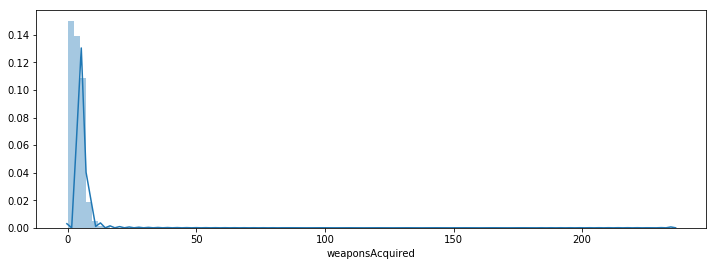

In [39]:
plt.figure(figsize=(12,4))
sns.distplot(train['weaponsAcquired'], bins=100)
plt.show()

In [40]:
display(train[train['weaponsAcquired'] >= 80].shape)
train[train['weaponsAcquired'] >= 80].head()

(19, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.11,0,0,0,44,...,0.7111,91,0.00,73.1499,50.14,2072.09,0,3187.00,False,0.000000
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.30,1,0,2,48,...,0.7500,98,0.00,178.8060,29.58,1399.44,3,1687.00,False,0.000000
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.00,0,0,0,24,...,0.8929,97,1.03,103.0000,29.87,1895.20,0,5299.21,False,0.000000
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.00,0,0,0,54,...,0.5600,80,0.00,0.0000,31.20,1596.00,0,653.10,False,0.000000
1592744,634a224c53444e,75fa7591d1538c,f900de1ec39fa5,9,0,1726.00,0,3,0,9,...,0.2000,11,43.47,3262.1400,20.79,3398.22,0,2888.80,False,0.130435


In [41]:
# Remove outliers
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

We should probably remove these outliers from our model. Do you agree?

Note that player 3f2bcf53b108c4 acquired 236 weapons in one game!

![Alt Text](https://media.giphy.com/media/69lWR6c8Afx9qeg2Tu/giphy.gif)

**Anomalies in supplies part 2 (heals)**

Most players us 5 healing items or less. We can again recognize some weird anomalies

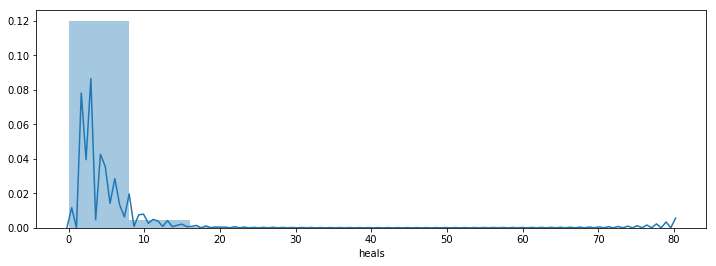

In [42]:
plt.figure(figsize=(12,4))
sns.distplot(train['heals'], bins=10)
plt.show()

In [43]:
# 40 or more healing items used
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40].head(10)

(135, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.0,0,0,47,43,...,0.9368,96,0.00,0.00,99.84,1868.88,49,6854.000,False,0.000000
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.0,0,1,43,21,...,0.9615,93,1.07,194.74,28.89,1639.24,47,3083.400,False,1.000000
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.0,0,0,52,49,...,0.8333,97,0.00,0.00,99.91,1415.22,54,1343.443,False,0.000000
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.0,0,0,42,45,...,0.8646,97,0.00,0.00,99.91,1822.07,52,7444.000,False,0.000000
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.0,0,0,48,43,...,0.8370,93,0.00,0.00,99.51,2009.46,53,5816.000,False,0.000000
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.0,0,0,42,44,...,0.9259,97,0.00,0.00,28.84,1333.85,44,2439.000,False,0.000000
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.0,0,0,40,52,...,0.8276,99,0.00,124.23,30.30,1984.65,43,4848.000,False,0.000000
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.0,2,1,47,25,...,0.9355,95,1.05,183.75,33.60,1425.90,53,3415.600,False,1.000000
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.0,0,8,41,9,...,0.8889,41,42.93,3733.32,58.83,2857.23,41,268.800,False,0.296296
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.5,3,1,44,3,...,0.9630,94,4.24,295.21,29.68,1915.42,51,4927.000,False,0.250000


In [44]:
# Remove outliers
train.drop(train[train['heals'] >= 40].index, inplace=True)

**Outlier conclusions**

We removed about 2000 players from our dataset. Do you think this is too much? Please let us know in the comments.

In [45]:
train.shape

(4444776, 38)

# Categorical Variables <a id="7"></a>

We will one hot encode the 'matchType' feature. 

In [46]:
print('There are {} different Match types in the dataset.'.format(train['matchType'].nunique()))

There are 16 different Match types in the dataset.


In [47]:
# One hot encode matchType
train = pd.get_dummies(train, columns=['matchType'])

# Take a look at the encoding
matchType_encoding = train.filter(regex='matchType')
matchType_encoding.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


There are a lot of groupId's and matchId's so one-hot encoding them is computational suicide.
We will turn them into category codes. That way we can still benefit from correlations between groups and matches in our machine learning algorithm.

In [48]:
# Turn groupId and match Id into categorical types
train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')

# Get category coding for groupId and matchID
train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

# Get rid of old columns
train.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
train[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,613591,30085
1,827582,32751
2,843273,3143
3,1340072,45260
4,1757338,20531


In [49]:
# Drop Id column, because it probably won't be useful for our Machine Learning algorithm,
# because the test set contains different Id's
train.drop(columns = ['Id'], inplace=True)

**voilà!**

# Preparation for Machine Learning <a id="8"></a>

## Sampling

We will take a sample of 500000 rows from our training set for easy debugging and exploration.

In [50]:
# Take sample for debugging and exploration
sample = 500000
df_sample = train.sample(sample)

## Split target variable, validation data, etc.

In [51]:
# Split sample into training data and target variable
df = df_sample.drop(columns = ['winPlacePerc']) #all columns except target
y = df_sample['winPlacePerc'] # Only target variable

In [52]:
# Function for splitting training and validation data
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
# Split data
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (440000, 51) Sample target shape:  (440000,) Sample validation shape:  (60000, 51)


## Set metrics (MAE)

[Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error) is the metric that is used for this competition. The scikit-learn library already programmed this metric for us so we don't have to implement it from scratch.

In [53]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error

# Function to print the MAE (Mean Absolute Error) score
# This is the metric used by Kaggle in this competition
def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## First basic Random Forest Model

In [54]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.03918668594642422, 'mae val: ', 0.06277318543905157]


# Feature Importance <a id="9"></a>

The [fastai](https://www.fast.ai/) library gives us an easy way to analyze feature importances from a random forest algorithm with just one line of code!

In [55]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols': df.columns,'imp' :
    m.feature_importances_}).sort_values('imp',ascending = False)

In [56]:
# What are the most predictive features according to our basic random forest model
fi = rf_feat_importance(m1, df); fi[:10]

,cols,imp
21,walkDistance,0.232329
30,totalDistance,0.203446
6,killPlace,0.149209
29,healsandboosts,0.070188
1,boosts,0.069645
22,weaponsAcquired,0.052227
5,heals,0.039708
10,longestKill,0.023206
16,rideDistance,0.018070
26,damageDealtNorm,0.017102


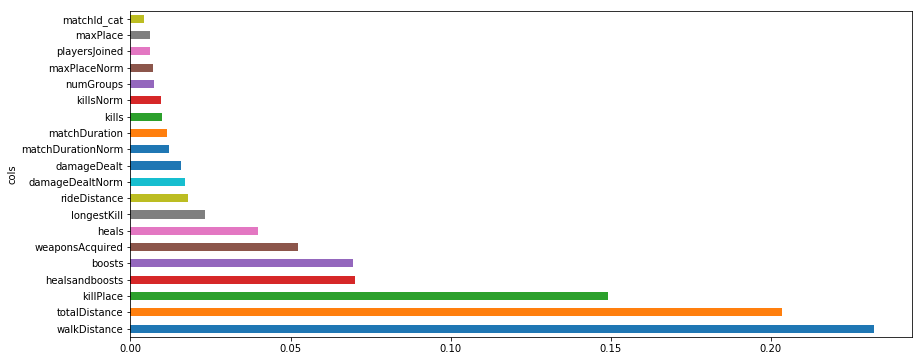

In [57]:
# Plot a feature importance graph for the 20 most important features
plot1 = fi[:20].plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot1

# Use this code if you want to save the figure
#fig = plot1.get_figure()
#fig.savefig("Feature_importances(AllFeatures).png")

In [58]:
#Keep only significant features
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

Significant features:  19


21         walkDistance
30        totalDistance
6             killPlace
29       healsandboosts
1                boosts
22      weaponsAcquired
5                 heals
10          longestKill
16         rideDistance
26      damageDealtNorm
2           damageDealt
28    matchDurationNorm
11        matchDuration
8                 kills
25            killsNorm
13            numGroups
27         maxPlaceNorm
24        playersJoined
12             maxPlace
Name: cols, dtype: object

In [59]:
# Make a DataFrame with only significant features
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

## Second Random Forest Model

This time we use only the top features to train a random forest model. This will likely improve results a little bit.

In [60]:
# Train model on top features
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

['mae train: ', 0.03686602641211185, 'mae val: ', 0.060173562808475765]


**Feature importance for top features**

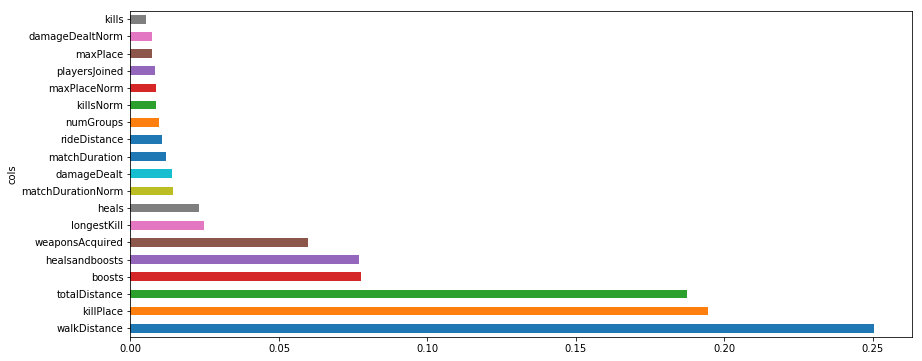

In [61]:
# Get feature importances of our top features
fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2

# Use this code if you want to save the figure
#fig = plot2.get_figure()
#fig.savefig("Feature_importances(TopFeatures).png")

## Correlations

**Dendrogram (to view correlation of features)**

[]

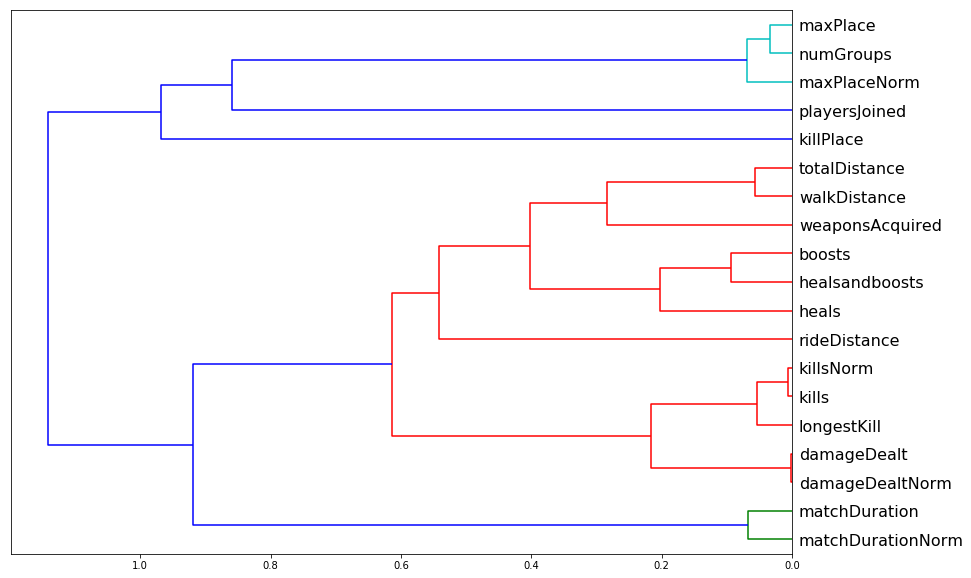

In [62]:
# Create a Dendrogram to view highly correlated features
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(14,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.plot()

In [63]:
# Use this code if you want to save the figure
#plt.savefig('Dendrogram.png')

**Correlation Heatmap**

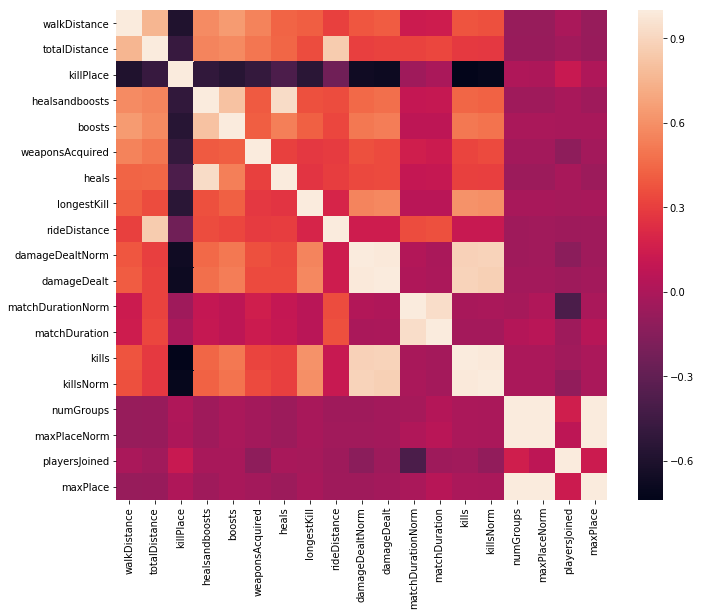

In [64]:
# Correlation heatmap
corr = df_keep.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Create heatmap
heatmap = sns.heatmap(corr)

In [65]:
# Use this code if you want to save the figure
#fig = heatmap.get_figure()
#fig.savefig("Heatmap(TopFeatures).png")

**Predictive quality of kills**

In [80]:
# Plot the predictive quality of kills 
# x_all = get_sample(train, 100000)
# ggplot(x_all, aes('kills','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

NameError: name 'get_sample' is not defined

**Predictive quality of walkDistance**

In [ ]:
# Plot the predictive quality of walkDistance
# x_all = get_sample(train, 100000)
# ggplot(x_all, aes('walkDistance','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

# Final Random Forest Model <a id="10"></a>

In [66]:
# Prepare data
val_perc_full = 0.12 # % to use for validation set
n_valid_full = int(val_perc_full * len(train)) 
n_trn_full = len(train)-n_valid_full
df_full = train.drop(columns = ['winPlacePerc']) # all columns except target
y = train['winPlacePerc'] # target variable
df_full = df_full[to_keep] # Keep only relevant features
X_train, X_valid = split_vals(df_full, n_trn_full)
y_train, y_valid = split_vals(y, n_trn_full)

print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (3911403, 19) Sample target shape:  (3911403,) Sample validation shape:  (533373, 19)


In [67]:
# Train final model
# You should get better results by increasing n_estimators
# and by playing around with the parameters
m3 = RandomForestRegressor(n_estimators=70, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)
m3.fit(X_train, y_train)
print_score(m3)

['mae train: ', 0.031160722960468193, 'mae val: ', 0.056090312183270506]


# Kaggle Submission <a id="11"></a>

In [68]:
# Add engineered features to the test set
test['headshot_rate'] = test['headshotKills'] / test['kills']
test['headshot_rate'] = test['headshot_rate'].fillna(0)
test['totalDistance'] = test['rideDistance'] + test['walkDistance'] + test['swimDistance']
test['playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['killsNorm'] = test['kills']*((100-test['playersJoined'])/100 + 1)
test['damageDealtNorm'] = test['damageDealt']*((100-test['playersJoined'])/100 + 1)
test['maxPlaceNorm'] = test['maxPlace']*((100-train['playersJoined'])/100 + 1)
test['matchDurationNorm'] = test['matchDuration']*((100-test['playersJoined'])/100 + 1)
test['healsandboosts'] = test['heals'] + test['boosts']
test['killsWithoutMoving'] = ((test['kills'] > 0) & (test['totalDistance'] == 0))

# Turn groupId and match Id into categorical types
test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')

# Get category coding for groupId and matchID
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes

# Remove irrelevant features from the test set
test_pred = test[to_keep].copy()

# Fill NaN with 0 (temporary)
test_pred.fillna(0, inplace=True)
test_pred.head()

,walkDistance,totalDistance,killPlace,healsandboosts,boosts,weaponsAcquired,heals,longestKill,rideDistance,damageDealtNorm,damageDealt,matchDurationNorm,matchDuration,kills,killsNorm,numGroups,maxPlaceNorm,playersJoined,maxPlace
0,588.0,588.0,73,0,0,1,0,0.00,0.0,55.5768,51.46,2034.72,1884,0,0.00,28,29.12,92,28
1,2017.0,6686.0,11,6,4,6,2,361.90,4669.0,186.2640,179.10,1883.44,1811,2,2.08,47,52.32,96,48
2,787.8,787.8,49,4,0,4,4,0.00,0.0,24.8040,23.40,1900.58,1793,0,0.00,27,28.56,94,28
3,1812.0,1812.0,54,0,0,3,0,0.00,0.0,72.7272,65.52,2035.74,1834,0,0.00,44,49.05,89,45
4,2963.0,2963.0,7,5,4,4,1,60.06,0.0,346.7100,330.20,1392.30,1326,3,3.15,27,28.84,95,28


In [70]:
# Make submission ready for Kaggle
# We use our final Random Forest model (m3) to get the predictions
predictions = np.clip(a = m3.predict(test_pred), a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : test['Id'], 'winPlacePerc' : predictions})

# Create submission file
pred_df.to_csv("submission.csv", index=False)

**Check of submission file**

In [71]:
# Last check of submission
print('Head of submission: ')
display(pred_df.head())
print('Tail of submission: ')
display(pred_df.tail())

Head of submission: 


,Id,winPlacePerc
0,9329eb41e215eb,0.227098
1,639bd0dcd7bda8,0.920082
2,63d5c8ef8dfe91,0.711940
3,cf5b81422591d1,0.534118
4,ee6a295187ba21,0.915071


Tail of submission: 


,Id,winPlacePerc
1934169,a316c3a13887d5,0.707409
1934170,5312146b27d875,0.392182
1934171,fc8818b5b32ad3,0.896387
1934172,a0f91e35f8458f,0.843805
1934173,3696fc9f3a42b2,0.038536
